In [388]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                             precision_recall_curve, f1_score, roc_curve)

from imblearn import over_sampling, under_sampling

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#raw = pd.read_csv('COVID-19_Case_Surveillance_Public_Use_Data_with_Geography.csv')

In [4]:
# pickle save the raw file
'''
with open('raw', 'wb') as to_write:
    pickle.dump(raw, to_write)
'''
    
'''
with open('raw','rb') as read_file:
    raw = pickle.load(read_file)
'''

"\nwith open('raw','rb') as read_file:\n    raw = pickle.load(read_file)\n"

In [5]:
#raw.head()

In [6]:
#raw.columns

In [7]:
#raw.case_month.unique()

In [8]:
#raw.info()

In [9]:
# Filter on the records for August to October 2021
'''
aug_oct_2021 = raw[(raw['case_month'] == '2021-10') |
                   (raw['case_month'] == '2021-09') |
                   (raw['case_month'] == '2021-08')]
'''

"\naug_oct_2021 = raw[(raw['case_month'] == '2021-10') |\n                   (raw['case_month'] == '2021-09') |\n                   (raw['case_month'] == '2021-08')]\n"

# Step 1. Load the pickle file for faster accessing the dataset

In [10]:
'''
# Pickle save the Aug to Oct 2021 file
with open('aug_oct_2021', 'wb') as to_write:
    pickle.dump(aug_oct_2021, to_write)
'''

# load the pickle file
with open('aug_oct_2021','rb') as read_file:
    aug_oct_2021 = pickle.load(read_file)

In [11]:
aug_oct_2021.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
1,2021-10,MO,29.0,PHELPS,29161.0,0 - 17 years,NaN,NaN,NaN,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Unknown,Missing,Unknown,NaN
3,2021-08,TN,47.0,CLAIBORNE,47025.0,0 - 17 years,Female,Missing,Missing,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN
7,2021-09,MN,27.0,BECKER,27005.0,18 to 49 years,Female,Unknown,Missing,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
14,2021-09,WI,55.0,SHAWANO,55115.0,50 to 64 years,Female,NaN,NaN,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,NaN,NaN
16,2021-09,CO,8.0,MONTEZUMA,8083.0,65+ years,Female,Missing,NaN,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Missing,NaN


In [12]:
# Select relevant columns to analysis
df = aug_oct_2021[['res_state', 'state_fips_code', 'age_group', 'sex', 'race', 'exposure_yn',
                   'symptom_status', 'underlying_conditions_yn', 'hosp_yn']]

## 1.1 Map US states to 4 different regions (1 to 4)

In [13]:
# Map US states to 4 regions
state_mapping = pd.read_excel('state-geocodes-v2020.xlsx', skiprows=5)

/Users/jli/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [253]:
df_region = df.merge(state_mapping[['Region', 'State (FIPS)']],
                     how='left', left_on='state_fips_code', right_on='State (FIPS)')

In [254]:
df_region.head()

,res_state,state_fips_code,age_group,sex,race,exposure_yn,symptom_status,underlying_conditions_yn,hosp_yn,Region,State (FIPS)
0,MO,29.0,0 - 17 years,NaN,NaN,Missing,Missing,NaN,Unknown,2.0,29.0
1,TN,47.0,0 - 17 years,Female,Missing,Missing,Missing,NaN,Missing,3.0,47.0
2,MN,27.0,18 to 49 years,Female,Unknown,Missing,Missing,NaN,Missing,2.0,27.0
3,WI,55.0,50 to 64 years,Female,NaN,Missing,Symptomatic,NaN,No,2.0,55.0
4,CO,8.0,65+ years,Female,Missing,Missing,Symptomatic,NaN,Missing,4.0,8.0


In [255]:
print('df_region has ', df_region.shape[0], ' rows')

df_region has  7955132  rows


In [258]:
df_region.hosp_yn.value_counts(dropna=False)

Missing    3901008
No         2652958
Unknown    1162362
Yes         238804
Name: hosp_yn, dtype: int64

## 1.2 Remove rows with NaN in any columns - this drops a lot of rows

In [256]:
# dropping rows with NaN in any columns
df_region_dropna = df_region.dropna(axis=0)

In [618]:
print('df_region_dropna has ', df_region_dropna.shape[0], ' rows')

df_region_dropna has  230564  rows


# Step 2. Feature engineering

## 2.1 Remove rows with hospitalization other than Yes and No

In [619]:
# Keep only 'yes' and 'no' for target column (hospitalization)
clean_df = df_region_dropna[(df_region_dropna['hosp_yn'] == 'Yes') | (df_region_dropna['hosp_yn'] == 'No')]

In [620]:
clean_df['hosp_yn'].replace('Yes', 1, inplace=True)
clean_df['hosp_yn'].replace('No', 0, inplace=True)

/Users/jli/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [621]:
clean_df.reset_index(drop=True, inplace=True)
clean_df.head()

,res_state,state_fips_code,age_group,sex,race,exposure_yn,symptom_status,underlying_conditions_yn,hosp_yn,Region,State (FIPS)
0,AR,5.0,18 to 49 years,Female,White,Missing,Symptomatic,Yes,0,3.0,5.0
1,OH,39.0,18 to 49 years,Female,Black,Missing,Symptomatic,Yes,0,2.0,39.0
2,TN,47.0,18 to 49 years,Male,Unknown,Yes,Symptomatic,Yes,0,3.0,47.0
3,NC,37.0,0 - 17 years,Female,Multiple/Other,Unknown,Symptomatic,Yes,0,3.0,37.0
4,FL,12.0,18 to 49 years,Female,White,Missing,Symptomatic,Yes,0,3.0,12.0


## 2.2 Feature engineering

In [622]:
#clean_df.dropna(axis=0, subset=['res_state', 'age_group', 'sex'], inplace=True)
clean_df = clean_df[clean_df.age_group != 'Missing']
clean_df = clean_df[(clean_df.sex != 'Missing') & (clean_df.sex != 'Unknown')]
clean_df['race'].replace(['Multiple/Other', 'Unknown', 'Missing', np.nan], 'Other', inplace=True)
clean_df['exposure_yn'].replace(['Unknown', 'Missing', np.nan], 'Other', inplace=True)
clean_df['symptom_status'].replace(['Unknown', 'Missing', np.nan], 'Other', inplace=True)
clean_df['underlying_conditions_yn'].replace(['Unknown', 'Missing', np.nan], 'Other', inplace=True)

## 2.3 Sanity checks

In [623]:
clean_df.age_group.value_counts(dropna=False)

18 to 49 years    81287
65+ years         37642
50 to 64 years    36995
0 - 17 years      25534
Name: age_group, dtype: int64

In [624]:
clean_df.sex.value_counts(dropna=False)

Female    104837
Male       76621
Name: sex, dtype: int64

In [625]:
clean_df.race.value_counts(dropna=False)

White                                     143891
Black                                      19918
Other                                      14863
Asian                                       1560
American Indian/Alaska Native                721
Native Hawaiian/Other Pacific Islander       505
Name: race, dtype: int64

In [626]:
clean_df.exposure_yn.value_counts(dropna=False)

Other    118394
Yes       63064
Name: exposure_yn, dtype: int64

In [627]:
clean_df.symptom_status.value_counts(dropna=False)

Symptomatic     170379
Other             6152
Asymptomatic      4927
Name: symptom_status, dtype: int64

In [628]:
clean_df.underlying_conditions_yn.value_counts(dropna=False)

Yes    174955
No       6503
Name: underlying_conditions_yn, dtype: int64

# Step 3. Preprocessing for categorical columns - One Hot Encoder

In [687]:
clean_df.shape

(181458, 11)

In [688]:
X = clean_df[['Region', 'age_group', 'sex', 'race', 'exposure_yn',
             'symptom_status', 'underlying_conditions_yn']]
y = clean_df['hosp_yn']

In [689]:
# Create the encoder
encoder = OneHotEncoder(handle_unknown="ignore")
#encoder = OneHotEncoder(drop='first')

# Apply the encoder on selected columns
X_encoded = encoder.fit_transform(X[['age_group', 'sex', 'race', 'exposure_yn',
                                     'symptom_status', 'underlying_conditions_yn', 'Region']])

In [690]:
# Get the columns names after applying the encoder
column_name = encoder.get_feature_names(['age_group', 'sex', 'race', 'exposure_yn',
                           'symptom_status', 'underlying_conditions_yn', 'Region'])
#column_name

In [691]:
# Examine the X table after OneHotEncoder
# Method 1
#one_hot_encoded_frame =  pd.DataFrame(X_encoded.todense(), columns=column_name)
#one_hot_encoded_frame.head()
# Method 2
#pd.DataFrame(X_encoded.toarray(), columns=column_name).head()

# Step 4. Preliminary Training

In [692]:
#X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_frame, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

## 4.1 Baseline probability

In [693]:
np.mean(y_train)

0.1423198269567254

## 4.2 Simple decision tree classifier (1 tree)

In [694]:
#decisiontree = DecisionTreeClassifier(max_depth=3)
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
print('Accuracy (train): ', decisiontree.score(X_train, y_train))
print('Accuracy (test) : ', decisiontree.score(X_test, y_test))

Accuracy (train):  0.8668903186696609
Accuracy (test) :  0.8682629780667915


Notice that the accuracy is almost entirely due to our tree classifies classifies all entries to "Not Hospitalized"

In [695]:
'''
# Visualize the simple tree (it works best when the tree depth is small like 3)
fig, axes = plt.subplots(figsize = (14,14), dpi=300)
plot_tree(decisiontree, feature_names=column_name, class_names=['No', 'Yes'], filled=True);
fig.savefig("decistion_tree.png")
'''

'\n# Visualize the simple tree (it works best when the tree depth is small like 3)\nfig, axes = plt.subplots(figsize = (14,14), dpi=300)\nplot_tree(decisiontree, feature_names=column_name, class_names=[\'No\', \'Yes\'], filled=True);\nfig.savefig("decistion_tree.png")\n'

In [696]:
y_predict = decisiontree.predict(X_test)
pd.DataFrame(y_test).value_counts()

hosp_yn
0          31209
1           5083
dtype: int64

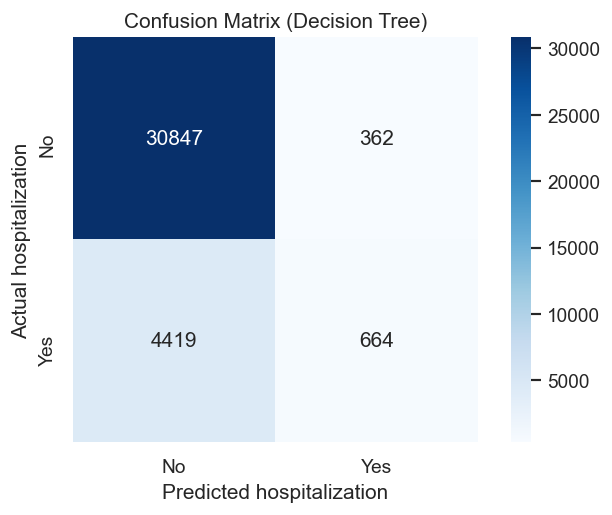

In [697]:
# Print confusion matrix
confusion = confusion_matrix(y_test, y_predict)
#fig = plt.figure(dpi=125)
fig, ax = plt.subplots(dpi=125)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])

ax.set_xlabel('Predicted hospitalization')
ax.set_ylabel('Actual hospitalization')
#plt.xlabel('Predicted hospitalization')
#plt.ylabel('Actual hospitalization')
plt.title('Confusion Matrix (Decision Tree)');
fig.savefig('confusion_matrix_base_tree.png', transparent=True, bbox_inches="tight")

In [698]:
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))
print('F1 score:  {:6.4f}'.format(f1_score(y_test, y_predict)))

Precision: 0.6472,   Recall: 0.1306
F1 score:  0.2174


### Recall score is bad due to the same reason - our tree classifies almost all records to "negative".

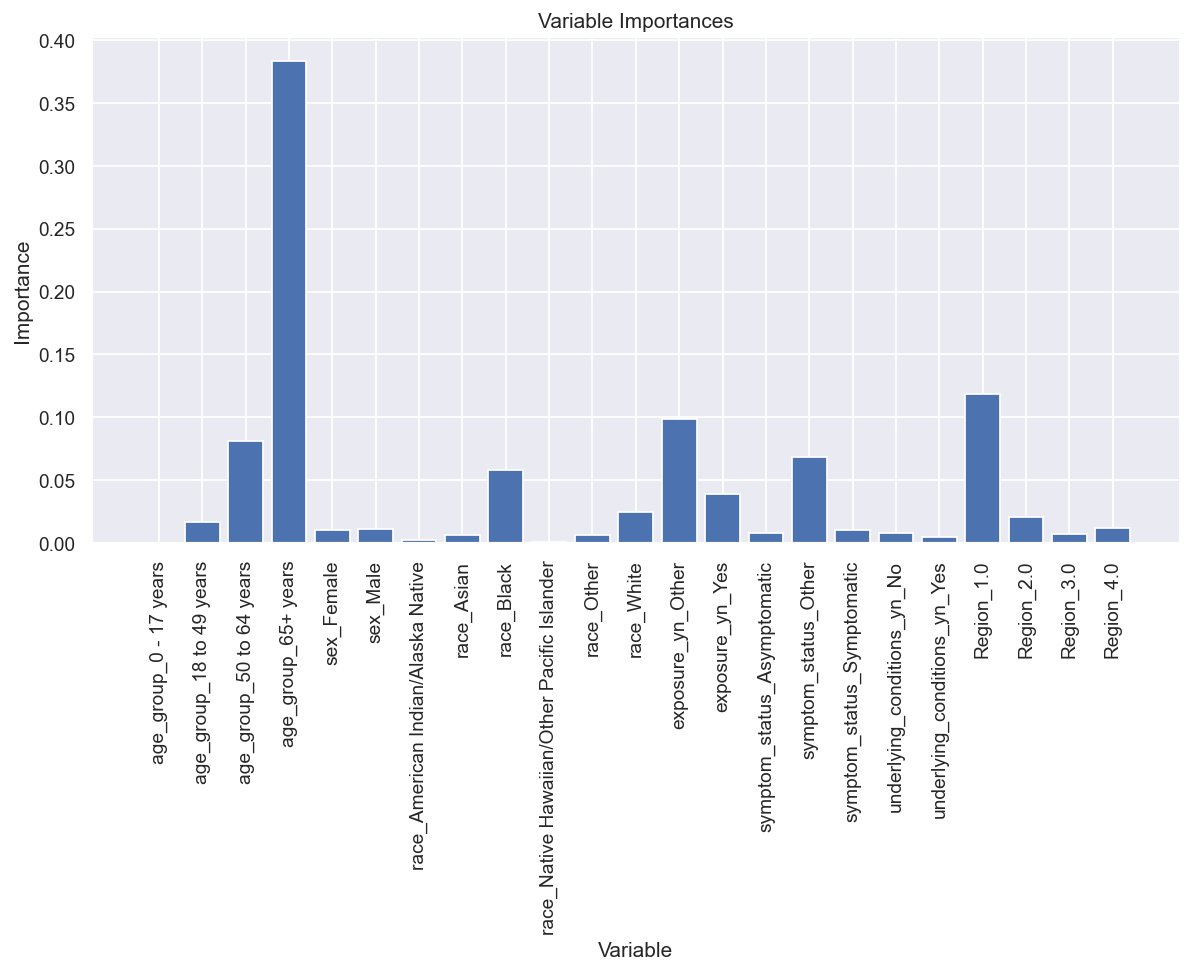

In [237]:
# Get numerical feature importances
importances = list(decisiontree.feature_importances_)

# List of tuples with variable and importance
#feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(column_name, importances)]

# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:45} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.figure(dpi=125, figsize=(10, 5))
plt.bar(x_values, importances, orientation='vertical')
# Tick labels for x axis
plt.xticks(x_values, column_name, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances');

# Step 5. class imbalance solutions

In [89]:
# Make a function to print metrics
def printscore(classifier, X_train, y_train, X_test, y_test):
    y_predict = classifier.predict(X_test)
    print('Accuracy (train): {:6.4f}'.format(classifier.score(X_train, y_train)))
    print('Accuracy (test) : {:6.4f}'.format(classifier.score(X_test, y_test)))
    print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict),
                                                         recall_score(y_test, y_predict)))
    print('F1 score:  {:6.4f}'.format(f1_score(y_test, y_predict)))
    return

## 5.1 Class Imbalance - Oversampling

In [90]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Create 4x as many positive samples
ratio = {1 : n_pos * 4, 0 : n_neg}

# Randomly oversample positives
ROS = over_sampling.RandomOverSampler(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = ROS.fit_resample(X_train, y_train)
#decisiontree = DecisionTreeClassifier(max_depth=3)
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_re, y_train_re)

DecisionTreeClassifier()

In [91]:
printscore(decisiontree, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7344
Accuracy (test) : 0.7924
Precision: 0.3540,   Recall: 0.5849
F1 score:  0.4410


## 5.2 Class Imbalance - Undersampling

In [409]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Sample 1/4 of negative samples
ratio = {1 : n_pos, 0 : n_neg // 4}

# Randomly undersample negative samples
RUS = under_sampling.RandomUnderSampler(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = RUS.fit_resample(X_train, y_train)

#decisiontree = DecisionTreeClassifier(max_depth=3)
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_re, y_train_re)

DecisionTreeClassifier()

In [410]:
printscore(decisiontree, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7330
Accuracy (test) : 0.7760
Precision: 0.3360,   Recall: 0.6138
F1 score:  0.4343


## 5.3 Class Imbalance - SMOTE

In [44]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Create 4x as many positive samples
ratio = {1 : n_pos * 4, 0 : n_neg}

# SMOTE oversampling for positives
smt = over_sampling.SMOTE(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = smt.fit_resample(X_train, y_train)

decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_re, y_train_re)

DecisionTreeClassifier()

In [45]:
printscore(decisiontree, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7369
Accuracy (test) : 0.7863
Precision: 0.3475,   Recall: 0.5985
F1 score:  0.4397


### It seems these class imbalance solutions have improved the performance a little bit. Let's try some other classifiers.

# Step 6. Preliminary training on different models

In [567]:
# Set up undersampling dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Sample partial negative samples
ratio = {1 : n_pos, 0 : n_neg // 4}

# Randomly undersample negative samples
RUS = under_sampling.RandomUnderSampler(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = RUS.fit_resample(X_train, y_train)

## 6.1 Logistic Regression

In [568]:
# Base logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_re, y_train_re)

printscore(logreg, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7238
Accuracy (test) : 0.7774
Precision: 0.3356,   Recall: 0.6016
F1 score:  0.4308


## 6.2 Random Forests

In [414]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_re, y_train_re)

RandomForestClassifier(random_state=42)

In [415]:
printscore(rf, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7330
Accuracy (test) : 0.7750
Precision: 0.3353,   Recall: 0.6170
F1 score:  0.4345


## 6.3 Gradient Boosted Trees

In [432]:
gbm = xgb.XGBClassifier(n_estimators=30000, #arbitrary large number
                        max_depth=3,
                        objective="reg:squarederror",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                        learning_rate=.1, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8)

eval_set=[(X_train_re, y_train_re),(X_test, y_test)] #tracking train/validation error as we go
fit_model = gbm.fit(X_train_re, y_train_re,
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True) #gives output log as below

[0]	validation_0-auc:0.73442	validation_1-auc:0.72949
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.74740	validation_1-auc:0.74296
[2]	validation_0-auc:0.75391	validation_1-auc:0.75020
[3]	validation_0-auc:0.75557	validation_1-auc:0.75183
[4]	validation_0-auc:0.75700	validation_1-auc:0.75354
[5]	validation_0-auc:0.75982	validation_1-auc:0.75763
[6]	validation_0-auc:0.76478	validation_1-auc:0.76305
[7]	validation_0-auc:0.76454	validation_1-auc:0.76202
[8]	validation_0-auc:0.76528	validation_1-auc:0.76296
[9]	validation_0-auc:0.76639	validation_1-auc:0.76411
[10]	validation_0-auc:0.76978	validation_1-auc:0.76844
[11]	validation_0-auc:0.77114	validation_1-auc:0.76961
[12]	validation_0-auc:0.77299	validation_1-auc:0.77208
[13]	validation_0-auc:0.77303	validation_1-auc:0.77194
[14]	validation_0-auc:0.77416	validation_1-auc:0.77346
[15]	validation_0-auc:0.7746

[146]	validation_0-auc:0.79063	validation_1-auc:0.79237
[147]	validation_0-auc:0.79063	validation_1-auc:0.79238
[148]	validation_0-auc:0.79063	validation_1-auc:0.79240
[149]	validation_0-auc:0.79062	validation_1-auc:0.79236
[150]	validation_0-auc:0.79062	validation_1-auc:0.79234
[151]	validation_0-auc:0.79065	validation_1-auc:0.79240
[152]	validation_0-auc:0.79066	validation_1-auc:0.79239
[153]	validation_0-auc:0.79066	validation_1-auc:0.79240
[154]	validation_0-auc:0.79068	validation_1-auc:0.79239
[155]	validation_0-auc:0.79068	validation_1-auc:0.79241
[156]	validation_0-auc:0.79071	validation_1-auc:0.79242
[157]	validation_0-auc:0.79071	validation_1-auc:0.79243
[158]	validation_0-auc:0.79071	validation_1-auc:0.79242
[159]	validation_0-auc:0.79072	validation_1-auc:0.79243
[160]	validation_0-auc:0.79072	validation_1-auc:0.79243
[161]	validation_0-auc:0.79075	validation_1-auc:0.79246
[162]	validation_0-auc:0.79074	validation_1-auc:0.79245
[163]	validation_0-auc:0.79073	validation_1-auc:

In [433]:
printscore(gbm, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7306
Accuracy (test) : 0.7813
Precision: 0.3430,   Recall: 0.6130
F1 score:  0.4399


## 6.4 Naive Bayes

In [570]:
# Original dataset
nb = BernoulliNB()
nb.fit(X_train, y_train)
printscore(nb, X_train, y_train, X_test, y_test)

Accuracy (train): 0.8480
Accuracy (test) : 0.8463
Precision: 0.4297,   Recall: 0.2975
F1 score:  0.3515


In [569]:
# Undersampling dataset
nb = BernoulliNB()
nb.fit(X_train_re, y_train_re)
printscore(nb, X_train, y_train, X_test, y_test)

Accuracy (train): 0.7579
Accuracy (test) : 0.7563
Precision: 0.3150,   Recall: 0.6299
F1 score:  0.4200


### We will choose random forests to proceed to the next step

# Step 7. Tuning on random forests classifier - class imbalance

### Target: To find a model with the highest F1 score
### Possible approach: class imbalance solutions, tuning hyperparameters, soft classification

## 7.1 Recall the baseline score

In [435]:
# basline score
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
printscore(rf, X_train, y_train, X_test, y_test)

Accuracy (train): 0.8669
Accuracy (test) : 0.8679
Precision: 0.6362,   Recall: 0.1328
F1 score:  0.2197


## 7.2 Class imbalance - changing class weight

In [436]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)
printscore(rf, X_train, y_train, X_test, y_test)

Accuracy (train): 0.7358
Accuracy (test) : 0.7345
Precision: 0.3048,   Recall: 0.6996
F1 score:  0.4246


## 7.3 Class imbalance - undersampling

In [478]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Sample 1/5 of negative samples
ratio = {1 : n_pos, 0 : n_neg // 5}

# Randomly undersample negative samples
RUS = under_sampling.RandomUnderSampler(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = RUS.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_re, y_train_re)

# Get the score
printscore(rf, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7255
Accuracy (test) : 0.7469
Precision: 0.3135,   Recall: 0.6785
F1 score:  0.4288


## 7.4 Class imbalance - oversampling

In [603]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Create 5x as many positive samples
ratio = {1 : n_pos * 5, 0 : n_neg}

# Randomly oversample positives
ROS = over_sampling.RandomOverSampler(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = ROS.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_re, y_train_re)

# Get the score
printscore(rf, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7263
Accuracy (test) : 0.7540
Precision: 0.3193,   Recall: 0.6681
F1 score:  0.4321


## 7.5 Class imbalance - customized class weight

In [439]:
# Customized class weight
weight = {1 : 5, 0 : 1}

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=weight)
rf.fit(X_train, y_train)
printscore(rf, X_train, y_train, X_test, y_test)

Accuracy (train): 0.7559
Accuracy (test) : 0.7543
Precision: 0.3197,   Recall: 0.6685
F1 score:  0.4325


In [440]:
# Find the best weight
f1 = []

for n in range(1, 11):
    weight = {1 : n, 0 : 1}
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=weight)
    rf.fit(X_train, y_train)
    f1.append(f1_score(y_test, rf.predict(X_test)))
    print('n: ', n)
    printscore(rf, X_train, y_train, X_test, y_test)

n:  1
Accuracy (train): 0.8669
Accuracy (test) : 0.8679
Precision: 0.6362,   Recall: 0.1328
F1 score:  0.2197
n:  2
Accuracy (train): 0.8512
Accuracy (test) : 0.8485
Precision: 0.4488,   Recall: 0.3577
F1 score:  0.3981
n:  3
Accuracy (train): 0.8205
Accuracy (test) : 0.8170
Precision: 0.3843,   Recall: 0.5095
F1 score:  0.4381
n:  4
Accuracy (train): 0.7965
Accuracy (test) : 0.7930
Precision: 0.3543,   Recall: 0.5810
F1 score:  0.4402
n:  5
Accuracy (train): 0.7559
Accuracy (test) : 0.7543
Precision: 0.3197,   Recall: 0.6685
F1 score:  0.4325
n:  6
Accuracy (train): 0.7358
Accuracy (test) : 0.7345
Precision: 0.3049,   Recall: 0.6996
F1 score:  0.4247
n:  7
Accuracy (train): 0.6978
Accuracy (test) : 0.6972
Precision: 0.2813,   Recall: 0.7472
F1 score:  0.4087
n:  8
Accuracy (train): 0.6768
Accuracy (test) : 0.6768
Precision: 0.2712,   Recall: 0.7751
F1 score:  0.4019
n:  9
Accuracy (train): 0.6617
Accuracy (test) : 0.6619
Precision: 0.2641,   Recall: 0.7919
F1 score:  0.3961
n:  10
Acc

### Weight of 1:5 could be a good start.

## 7.6 Class imbalance - undersampling + soft classification on test set

In [460]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Sample 1/5 of negative samples
ratio = {1 : n_pos, 0 : n_neg // 5}

# Randomly undersample negative samples
RUS = under_sampling.RandomUnderSampler(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = RUS.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_re, y_train_re)

# Get the curves
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

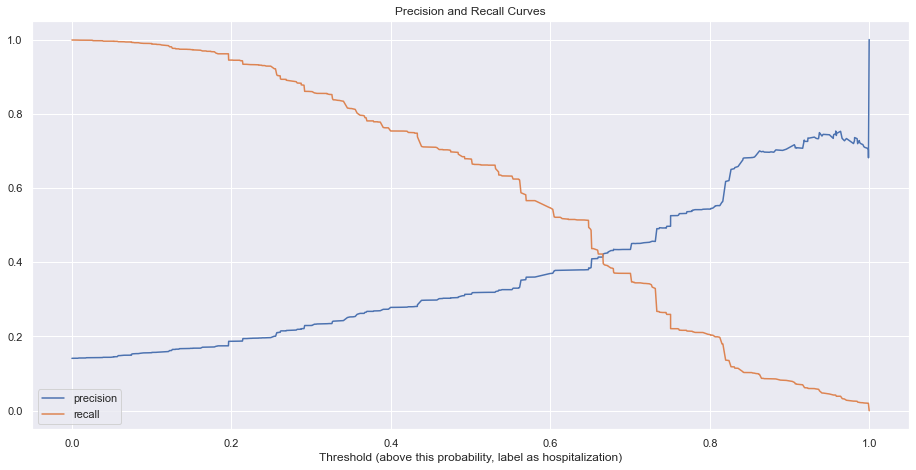

In [461]:
plt.figure(figsize=(14, 7))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hospitalization)');
plt.title('Precision and Recall Curves');

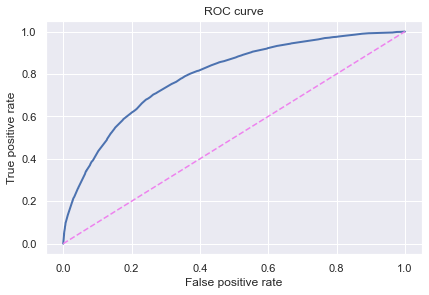

In [444]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [465]:
# What about the threshold of 0.6?
y_predict = (rf.predict_proba(X_test)[:, 1] > 0.6)
f1_score(y_test, y_predict)

0.4411484771573605

In [453]:
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict),
                                                     recall_score(y_test, y_predict)))
print('F1 score:  {:6.4f}'.format(f1_score(y_test, y_predict)))

Precision: 0.3696,   Recall: 0.5471
F1 score:  0.4411


## 7.7 SMOTE to complete the analysis. However, it's computationally expensive.

In [604]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Create 4x as many positive samples
ratio = {1 : n_pos * 5, 0 : n_neg}

# SMOTE oversampling for positives
smt = over_sampling.SMOTE(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = smt.fit_resample(X_train, y_train)

DecisionTreeClassifier()

In [607]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_re, y_train_re)

# Get the score
printscore(rf, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7295
Accuracy (test) : 0.7489
Precision: 0.3151,   Recall: 0.6754
F1 score:  0.4297


# Step 8. Tuning hyperparameters

### Set up undersampling dataset

In [699]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Sample 1/5 of negative samples
ratio = {1 : n_pos, 0 : n_neg // 5}

# Randomly undersample negative samples
RUS = under_sampling.RandomUnderSampler(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = RUS.fit_resample(X_train, y_train)

## 8.1 Randomized Search CV

In [498]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
               #'bootstrap': bootstrap}

In [499]:
random_grid

{'n_estimators': [100, 225, 350, 475, 600],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [500]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                               scoring='f1', cv=3, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_re, y_train_re)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 225, 350, 475,
                                                         600]},
                   random_state=42, scoring='f1', verbose=3)

In [501]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 60}

In [491]:
#rf_random.cv_results_

## 8.2 Check the scores of the best params from randomized CV

In [663]:
rf = RandomForestClassifier(n_estimators=100,
                            min_samples_split=5,
                            min_samples_leaf=4,
                            max_features='auto',
                            max_depth=60,
                            bootstrap=True,
                            random_state=42,
                            n_jobs=-1)
rf.fit(X_train_re, y_train_re)

printscore(rf, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7245
Accuracy (test) : 0.7482
Precision: 0.3148,   Recall: 0.6783
F1 score:  0.4301


## 8.3 Grid search

In [504]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [100]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

In [506]:
# Fit the grid search to the data
grid_search.fit(X_train_re, y_train_re)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [50, 60, 70, 80, 90, 100, None],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [100]},
             verbose=2)

In [507]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 100}

In [700]:
rf = RandomForestClassifier(n_estimators=100,
                            min_samples_split=5,
                            min_samples_leaf=4,
                            max_depth=90,
                            random_state=42,
                            n_jobs=-1)
rf.fit(X_train_re, y_train_re)

printscore(rf, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7245
Accuracy (test) : 0.7482
Precision: 0.3148,   Recall: 0.6783
F1 score:  0.4301


## 8.4 Soft classifier

In [701]:
# What about the threshold of 0.45?
y_predict = (rf.predict_proba(X_test)[:, 1] > 0.45)

print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict),
                                                     recall_score(y_test, y_predict)))
print('F1 score:  {:6.4f}'.format(f1_score(y_test, y_predict)))

Precision: 0.2990,   Recall: 0.7100
F1 score:  0.4208


# Step 9. Feature Importances

In [702]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
#feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(column_name, importances)]

# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
#[print('Variable: {:45} Importance: {}'.format(*pair)) for pair in feature_importances];

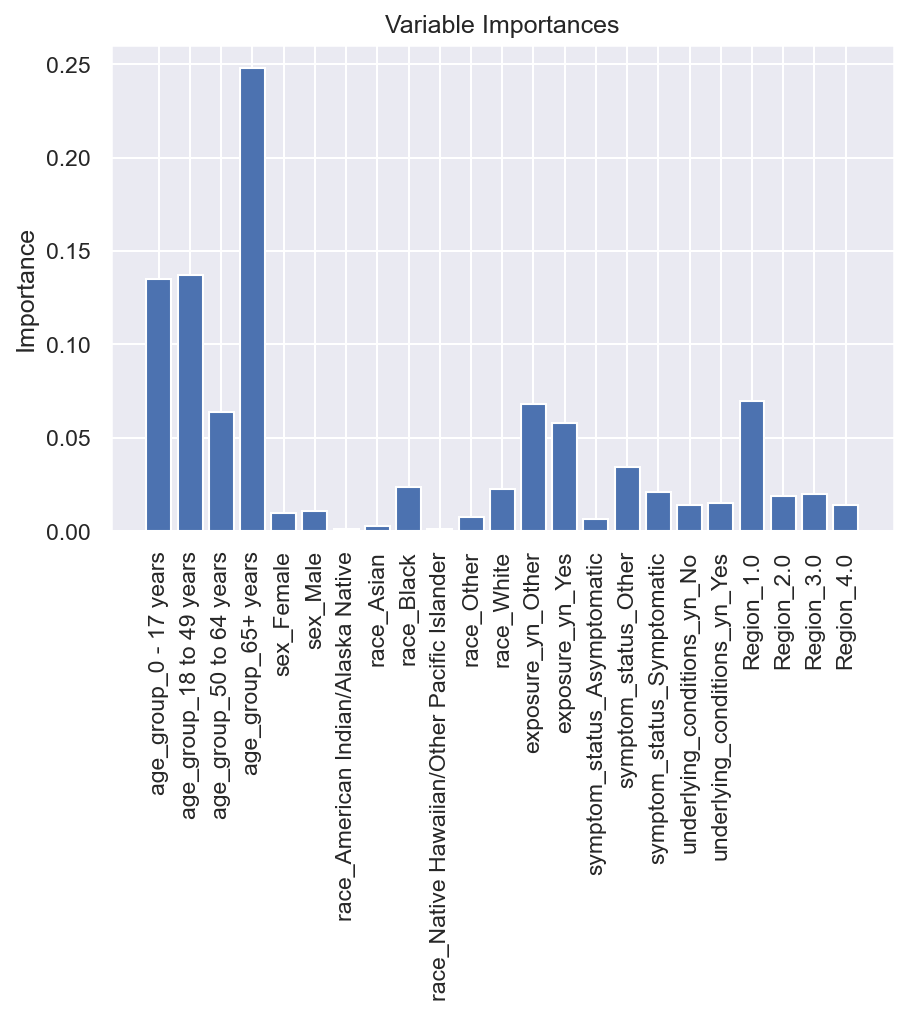

In [703]:
# Set the style
#plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
fig, ax = plt.subplots(dpi=150)
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, column_name, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
#plt.xlabel('Variable')
plt.title('Variable Importances');
fig.savefig('variable_importances_final.png', transparent=True, bbox_inches="tight")

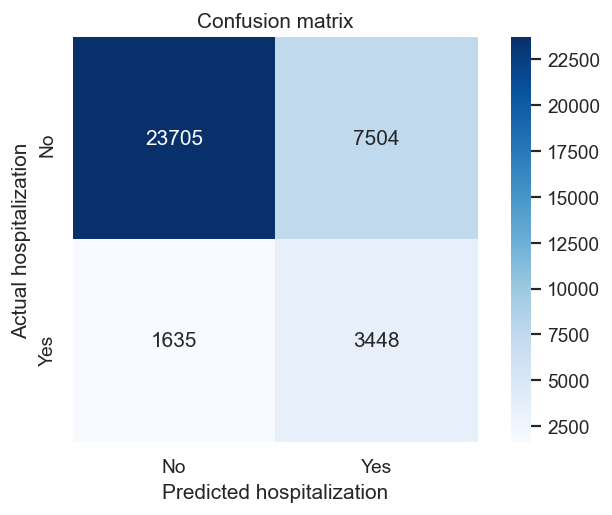

In [706]:
sns.set_theme()

# Print confusion matrix
y_predict = rf.predict(X_test)
confusion = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(dpi=125)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])

plt.xlabel('Predicted hospitalization')
plt.ylabel('Actual hospitalization')
plt.title('Confusion matrix');
fig.savefig('confusion_matrix_final.png', transparent=True, bbox_inches="tight")

In [717]:
recall_curve.shape

(604,)

In [718]:
f1_curve = 2 * recall_curve * precision_curve / (recall_curve + precision_curve)

In [719]:
f1_curve.shape

(604,)

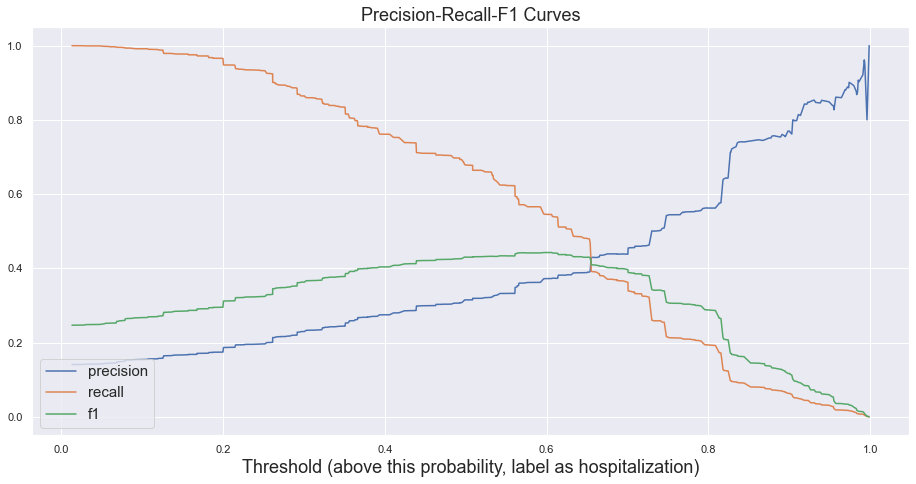

In [724]:
# Get the curves
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(14, 7))
#fig, ax = plt.subplots(dpi=125)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(threshold_curve, f1_curve[1:], label='f1')
plt.legend(loc='lower left', fontsize=15)
plt.xlabel('Threshold (above this probability, label as hospitalization)', fontsize=18);
plt.title('Precision-Recall-F1 Curves', fontsize=18);
fig.savefig('precision_vs_recall_final.png', transparent=True, bbox_inches="tight")

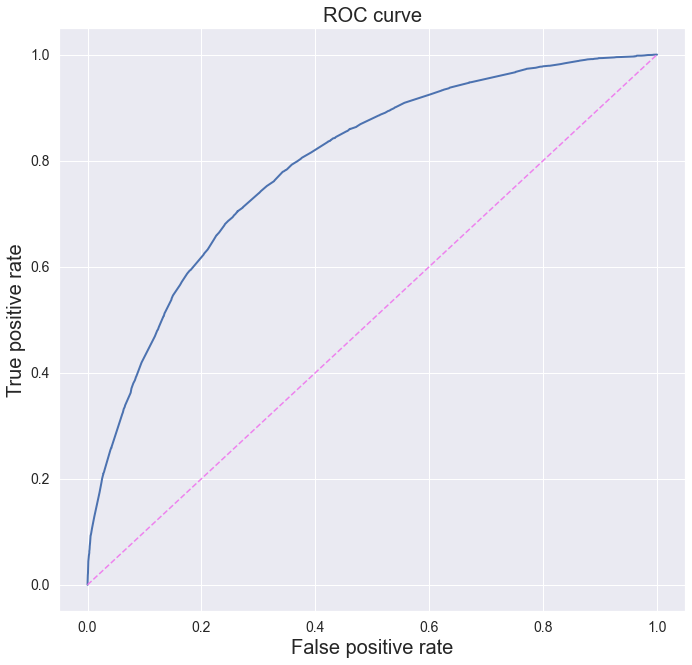

In [735]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(10, 10))
#plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.title('ROC curve', fontsize=20);
fig.savefig('ROC_curve_final.png', transparent=True, bbox_inches="tight")

# Step 10. Go back and see if I can improve the quality of the dataset
## Restart after step 1.1 - and only working with October 2021 data

In [346]:
oct_2021 = aug_oct_2021[aug_oct_2021['case_month'] == '2021-10']

In [349]:
# Select relevant columns to analysis
df_v2 = oct_2021[['res_state', 'state_fips_code', 'age_group', 'sex', 'race', 'exposure_yn',
                  'symptom_status', 'underlying_conditions_yn', 'hosp_yn']]

In [350]:
df_region_v2 = df_v2.merge(state_mapping[['Region', 'State (FIPS)']],
                           how='left', left_on='state_fips_code', right_on='State (FIPS)')

In [352]:
# Keep only 'yes' and 'no' for target column (hospitalization)
clean_df_v2 = df_region_v2[(df_region_v2['hosp_yn'] == 'Yes') | (df_region_v2['hosp_yn'] == 'No')]

## 10.1 Feature engineering

In [371]:
#clean_df_v2.dropna(axis=0, subset=['res_state', 'age_group', 'sex'], inplace=True)
clean_df_v2.dropna(axis=0, subset=['age_group', 'sex', 'Region'], inplace=True)
clean_df_v2 = clean_df_v2[clean_df_v2.age_group != 'Missing']
clean_df_v2 = clean_df_v2[(clean_df_v2.sex != 'Missing') & (clean_df_v2.sex != 'Unknown')]
clean_df_v2['race'].replace(['Multiple/Other', 'Unknown', 'Missing', 'Native Hawaiian/Other Pacific Islander',
                             'American Indian/Alaska Native', 'Asian', np.nan], 'Other', inplace=True)
clean_df_v2['exposure_yn'].replace(['Missing', np.nan], 'Unknown', inplace=True)
clean_df_v2['symptom_status'].replace(['Missing', np.nan], 'Unknown', inplace=True)
clean_df_v2['underlying_conditions_yn'].replace(['Unknown', np.nan], 'Missing', inplace=True)
clean_df_v2['hosp_yn'].replace('Yes', 1, inplace=True)
clean_df_v2['hosp_yn'].replace('No', 0, inplace=True)
clean_df_v2.shape[0]

534283

In [372]:
# Set up X and y with selected columns
X_v2 = clean_df_v2[['age_group', 'sex', 'race', 'exposure_yn', 'symptom_status', 'Region']]
y_v2 = clean_df_v2['hosp_yn']

In [375]:
y_v2.value_counts()

0    492397
1     41886
Name: hosp_yn, dtype: int64

## 10.2 One-Hot-Encoder

In [373]:
# Create the encoder
encoder = OneHotEncoder(handle_unknown="ignore")

# Apply the encoder on selected columns
X_encoded_v2 = encoder.fit_transform(X_v2[['age_group', 'sex', 'race', 'exposure_yn',
                                           'symptom_status', 'Region']])

# Get the columns names after applying the encoder
column_name_v2 = encoder.get_feature_names(['age_group', 'sex', 'race', 'exposure_yn',
                                            'symptom_status', 'Region'])

In [374]:
column_name_v2

array(['age_group_0 - 17 years', 'age_group_18 to 49 years',
       'age_group_50 to 64 years', 'age_group_65+ years', 'sex_Female',
       'sex_Male', 'race_Black', 'race_Other', 'race_White',
       'exposure_yn_Unknown', 'exposure_yn_Yes',
       'symptom_status_Asymptomatic', 'symptom_status_Symptomatic',
       'symptom_status_Unknown', 'Region_1.0', 'Region_2.0', 'Region_3.0',
       'Region_4.0'], dtype=object)

## 10.3 Fit a simple tree

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_v2, y_v2, test_size=0.2, random_state=42)
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
printscore(decisiontree, X_train, y_train, X_test, y_test)

Accuracy (train): 0.9229
Accuracy (test) : 0.9216
Precision: 0.5899,   Recall: 0.0360
F1 score:  0.0679


## 10.4 Undersampling and fit a tree

In [378]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Sample only 1/10 of negative samples
ratio = {1 : n_pos, 0 : n_neg // 10}

# Randomly undersample negative samples
RUS = under_sampling.RandomUnderSampler(sampling_strategy=ratio, random_state=42)
X_train_re, y_train_re = RUS.fit_resample(X_train, y_train)

decisiontree.fit(X_train_re, y_train_re)
printscore(decisiontree, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7322
Accuracy (test) : 0.7750
Precision: 0.2111,   Recall: 0.6723
F1 score:  0.3213


## 10.5 Fit random forests

In [385]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_re, y_train_re)

# Get the score
printscore(rf, X_train_re, y_train_re, X_test, y_test)

Accuracy (train): 0.7322
Accuracy (test) : 0.7745
Precision: 0.2109,   Recall: 0.6734
F1 score:  0.3213


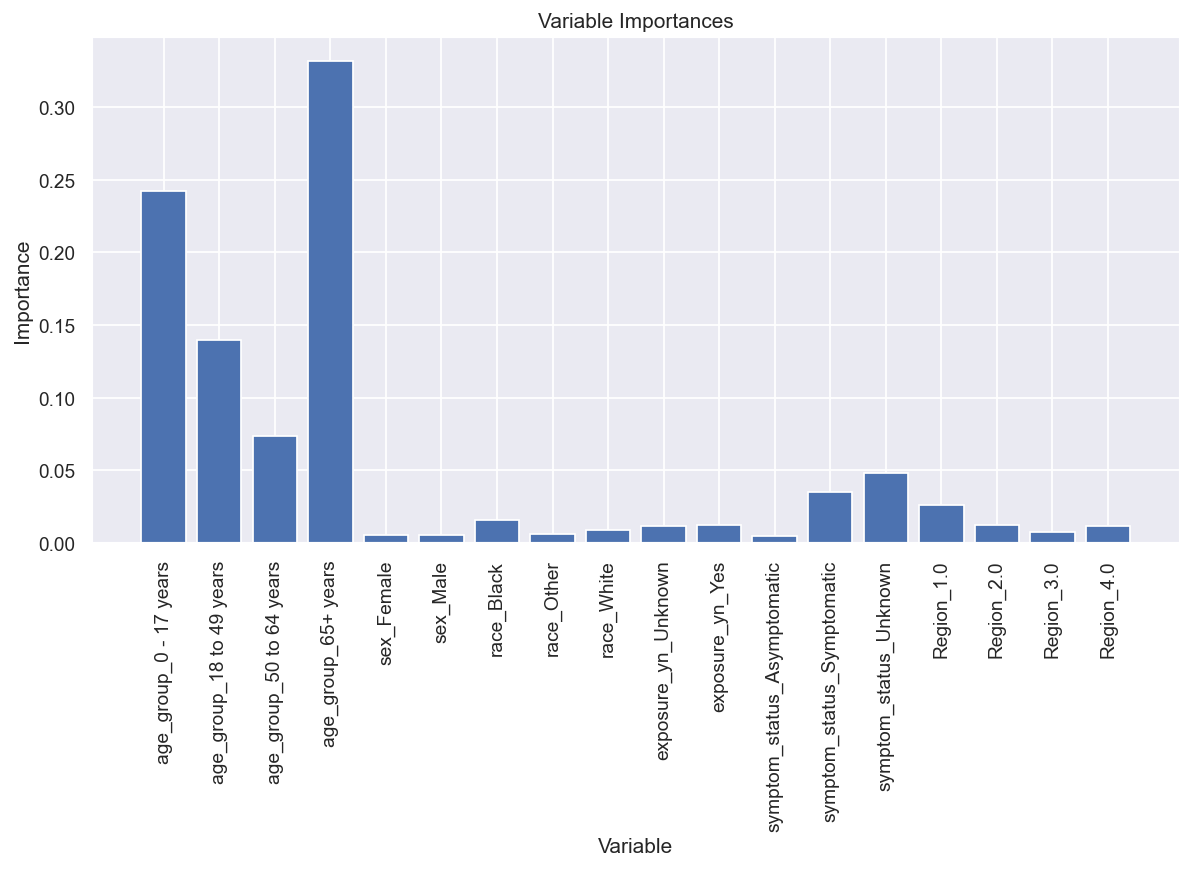

In [387]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.figure(dpi=125, figsize=(10, 5))
plt.bar(x_values, importances, orientation='vertical')
# Tick labels for x axis
plt.xticks(x_values, column_name_v2, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances');

### So far, we are not able to improve F1 score further.

# Step 11. Naive Bayes

In [398]:
nb = BernoulliNB()
nb.fit(X_train_re, y_train_re)

BernoulliNB()

In [399]:
printscore(nb, X_train, y_train, X_test, y_test)

Accuracy (train): 0.7656
Accuracy (test) : 0.7650
Precision: 0.2000,   Recall: 0.6554
F1 score:  0.3065


### I don't think we are going anywhere with Naive Bayes.